<div style="text-align: center;">
    <a href="https://www.ip-paris.fr/en/education/masters/applied-mathematics-and-statistics-program/master-year-2-data-science">
        <img border="0" src="https://www.ip-paris.fr/sites/default/files/presse/Charte%20Graphique/2025/LOGOTYPE-7-ECOLES-Vertical.png" width="90%"></a>
</div>

# RAMP on Satellites decay date prediction

<i> Erwan CELANIE, Jaishan BURTON ELMO, Kevin ALINEJAD, Nizar ZEROUALE, Jad AOUAD, Othmane LKHALIDI</i>

## Introduction  

### The disintegration of satellites  

Artificial satellites placed in orbit around the Earth do not remain operational indefinitely. Over time, Earth's gravitational pull, atmospheric drag, and other factors influence their trajectory, eventually leading to their disintegration (or decay). Accurately predicting the decay date of satellites is a crucial challenge for managing space traffic and ensuring the safety of orbital infrastructures.  

### The Space Track database  

The data used for this challenge comes from the <a href="https://www.space-track.org//basicspacedata/query/class/gp/decay_date/<>null-val/orderby/NORAD_CAT_ID/format/html">**Space-Track** platform</a>, which centralizes information on orbiting objects, including active satellites, space debris, and decommissioned spacecraft. These data are collected by the **United States Space Surveillance Network (SSN)** and made available for analysis and orbital forecasting.  

# Exploratory data analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
pd.set_option('display.max_columns', None)

## Get access to the training data

In [2]:
import problem

X_df, y = problem.get_train_data()
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16886 entries, 1 to 25009
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CCSDS_OMM_VERS       16886 non-null  float64       
 1   COMMENT              16886 non-null  object        
 2   CREATION_DATE        16886 non-null  object        
 3   ORIGINATOR           16886 non-null  object        
 4   CENTER_NAME          16886 non-null  object        
 5   REF_FRAME            16886 non-null  object        
 6   TIME_SYSTEM          16886 non-null  object        
 7   MEAN_ELEMENT_THEORY  16886 non-null  object        
 8   EPOCH                16886 non-null  object        
 9   MEAN_MOTION          16886 non-null  float64       
 10  ECCENTRICITY         16886 non-null  float64       
 11  INCLINATION          16886 non-null  float64       
 12  RA_OF_ASC_NODE       16886 non-null  float64       
 13  ARG_OF_PERICENTER    16886 non-null 

## The features

<span style="color:red">Red variables</span> are identifiers, labels, or other human-annotated features, so they should not be used as input in the prediction model.
<span style="color:lightblue">Light blue variables</span> are legal but not likely to contribute significant information to the prediction.
Black variables are definitely discriminative.

<ul> <li> <code><b><span style="color:red">CCSDS_OMM_VERS</span></b></code>: Version of the CCSDS Orbit Mean-Elements Message (OMM) format. <li> <code><b><span style="color:red">COMMENT</span></b></code>: General information about the satellite data source. <li> <code><b><span style="color:red">CREATION_DATE</span></b></code>: Date when this dataset was created. <li> <code><b><span style="color:red">ORIGINATOR</span></b></code>: Organization responsible for the data (e.g., 18 SPCS). </ul>
Satellite Metadata
<ul> <li> <code><b><span style="color:red">OBJECT_ID</span></b></code>: Unique identifier for the satellite. <li> <code><b><span style="color:red">OBJECT_NAME</span></b></code>: Name of the satellite. <li> <code><b><span style="color:red">NORAD_CAT_ID</span></b></code>: NORAD catalog identifier assigned to the satellite. <li> <code><b>COUNTRY_CODE</b></code>: Country of origin of the satellite. <li> <code><b>OBJECT_TYPE</b></code>: Type of object (e.g., PAYLOAD, DEBRIS). </ul>
Orbital Elements
<ul> <li> <code><b><span style="color:black">EPOCH</span></b></code>: Epoch time for the provided orbital elements. <li> <code><b><span style="color:black">MEAN_MOTION</span></b></code>: Number of revolutions per day (rev/day). <li> <code><b><span style="color:black">ECCENTRICITY</span></b></code>: Measure of the orbit's deviation from a perfect circle. <li> <code><b><span style="color:black">INCLINATION</span></b></code>: Orbital inclination angle (in degrees). <li> <code><b><span style="color:black">RA_OF_ASC_NODE</span></b></code>: Right Ascension of the Ascending Node (in degrees). <li> <code><b><span style="color:black">ARG_OF_PERICENTER</span></b></code>: Argument of perigee/pericenter (in degrees). <li> <code><b><span style="color:black">MEAN_ANOMALY</span></b></code>: Mean anomaly at the epoch (in degrees). </ul>
Tracking and Atmospheric Drag Parameters
<ul> <li> <code><b><span style="color:red">ELEMENT_SET_NO</span></b></code>: Version number of the orbital element set. <li> <code><b><span style="color:black">REV_AT_EPOCH</span></b></code>: Number of revolutions completed since launch at the epoch time. <li> <code><b><span style="color:black">BSTAR</span></b></code>: Drag coefficient affecting atmospheric resistance. <li> <code><b><span style="color:black">MEAN_MOTION_DOT</span></b></code>: First derivative of mean motion (rad/s²), indicating acceleration due to drag. <li> <code><b><span style="color:black">MEAN_MOTION_DDOT</span></b></code>: Second derivative of mean motion (rad/s³), usually close to zero. </ul>
Orbital Characteristics
<ul> <li> <code><b><span style="color:black">SEMIMAJOR_AXIS</span></b></code>: Semi-major axis of the orbit (in km). <li> <code><b><span style="color:black">PERIOD</span></b></code>: Orbital period of the satellite (in minutes). <li> <code><b><span style="color:black">APOAPSIS</span></b></code>: Maximum altitude reached by the satellite (in km). <li> <code><b><span style="color:black">PERIAPSIS</span></b></code>: Minimum altitude reached by the satellite (in km). </ul>
Satellite Type and Physical Attributes
<ul> <li> <code><b><span style="color:lightblue">RCS_SIZE</span></b></code>: Estimated radar cross-section category (SMALL, MEDIUM, LARGE). <li> <code><b><span style="color:black">RCS_VALUE</span></b></code>: Numerical radar cross-section value. </ul>
Launch and Decay Information
<ul> <li> <code><b><span style="color:red">LAUNCH_DATE</span></b></code>: Date when the satellite was launched. <li> <code><b><span style="color:red">DECAY_DATE</span></b></code>: Date of satellite disintegration (target, label to predict). </ul>
Additional Tracking Data
<ul> <li> <code><b><span style="color:red">FILE</span></b></code>: Internal file reference ID. <li> <code><b><span style="color:red">GP_ID</span></b></code>: General Perturbation ID. <li> <code><b><span style="color:lightblue">TLE_LINE0</span></b></code>: First line of the Two-Line Element Set (TLE) for tracking. <li> <code><b><span style="color:lightblue">TLE_LINE1</span></b></code>: Second line of the TLE containing orbital elements. <li> <code><b><span style="color:lightblue">TLE_LINE2</span></b></code>: Third line of the TLE containing additional tracking data. </ul>

In [3]:
X_df.head()

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,FILE,GP_ID
1,3.0,GENERATED VIA SPACE-TRACK.ORG API,2023-10-07T17:28:49,18 SPCS,EARTH,TEME,UTC,SGP4,2023-10-07T02:47:45.242304,16.479814,0.001069,97.1006,355.5139,266.1137,93.8945,0,U,999,16421,0.000215,0.140084,0.000002,6522.793,87.380,151.633,137.684,PAYLOAD,MEDIUM,ARGN,2020-11-06,TSC,4027321,238643749
2,3.0,GENERATED VIA SPACE-TRACK.ORG API,2023-05-24T06:26:12,18 SPCS,EARTH,TEME,UTC,SGP4,2023-05-23T18:33:11.428416,15.790044,0.002217,98.7839,86.7317,160.2595,199.9530,0,U,999,23674,0.012126,0.025150,0.000000,6711.397,91.197,348.143,318.382,DEBRIS,MEDIUM,US,1999-12-12,AFWTR,3915786,232409087
3,3.0,GENERATED VIA SPACE-TRACK.ORG API,2024-10-02T19:24:27,18 SPCS,EARTH,TEME,UTC,SGP4,2024-10-01T06:19:57.433152,16.514244,0.000937,97.0439,293.7887,285.9496,74.0778,0,U,999,31867,0.000148,0.161708,0.000002,6513.724,87.197,141.690,129.489,PAYLOAD,MEDIUM,JPN,2019-01-18,KSCUT,4512136,269511738
4,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-02-15T07:46:15,18 SPCS,EARTH,TEME,UTC,SGP4,2025-02-15T05:56:26.077920,16.438352,0.000548,53.0195,299.3636,224.8203,229.5282,0,U,999,22329,0.000518,0.136493,0.000012,6533.757,87.600,159.205,152.040,PAYLOAD,LARGE,US,2021-02-04,AFETR,4641356,280776657
5,3.0,GENERATED VIA SPACE-TRACK.ORG API,2008-07-23T23:55:14,18 SPCS,EARTH,TEME,UTC,SGP4,2008-07-23T23:02:09.292992,16.247275,0.001399,98.6053,359.2413,279.9671,90.7511,0,U,999,45954,0.001344,0.037679,0.000003,6584.888,88.630,215.967,197.539,DEBRIS,SMALL,PRC,1999-10-14,TSC,583048,67229755


## Data exploration

In [4]:
def plot_histograms(df, columns, bins=30, figsize=(15, 10)):
    """
    Plot histograms for numerical variables.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    columns (list): List of numerical columns to plot.
    bins (int): Number of bins for the histogram.
    figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)
    for i, col in enumerate(columns, 1):
        plt.figure(figsize=(4, 3))
        sns.histplot(df[col], bins=bins, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x1000 with 0 Axes>

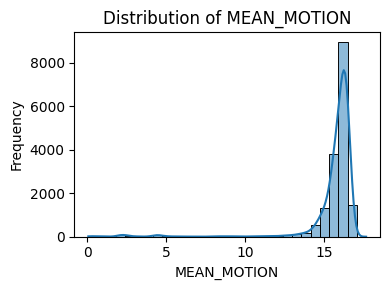

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


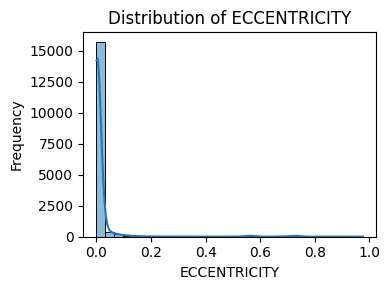

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


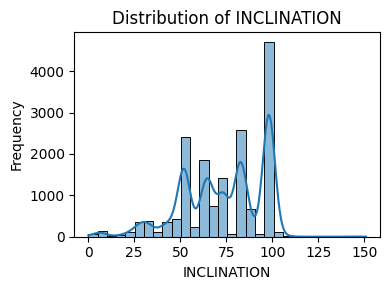

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


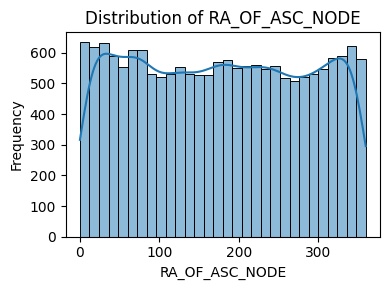

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


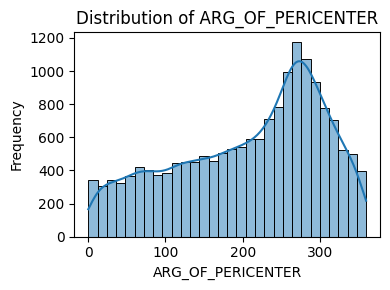

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


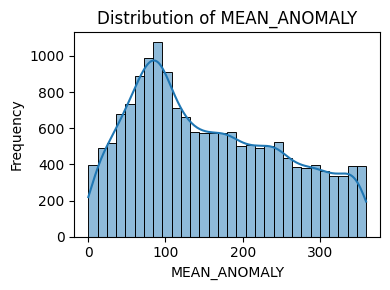

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


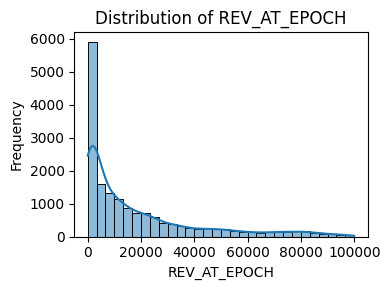

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


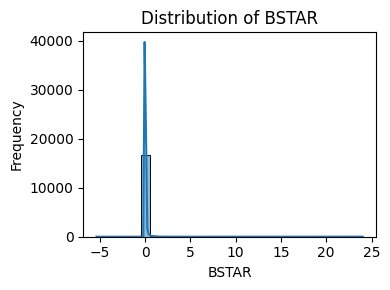

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


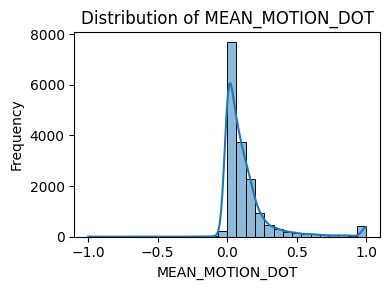

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


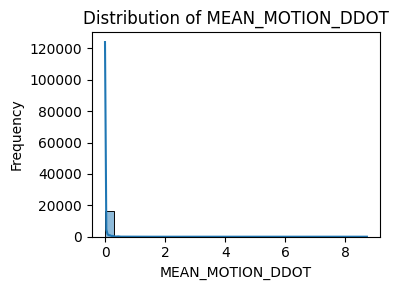

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


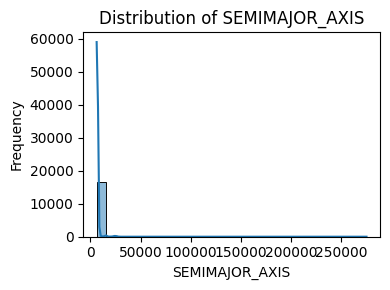

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


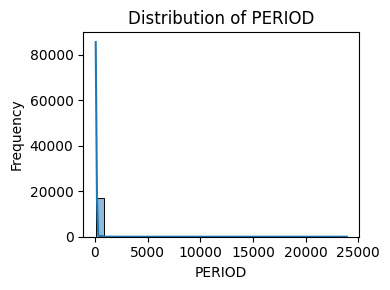

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


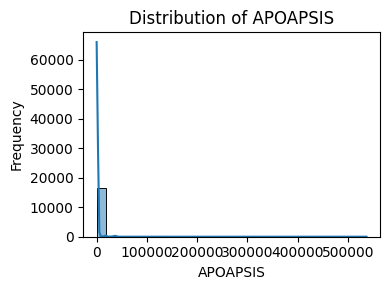

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


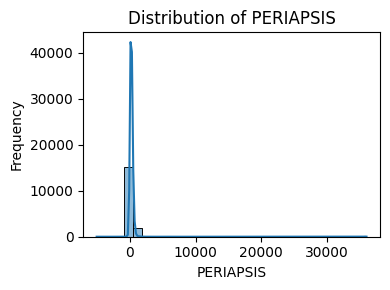

In [5]:
# List of numerical discriminative variables
numerical_discriminative_vars = [
    'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 
    'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'REV_AT_EPOCH', 'BSTAR', 
    'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD', 
    'APOAPSIS', 'PERIAPSIS'
]

# Plot histograms
plot_histograms(X_df, numerical_discriminative_vars)

In [6]:
def plot_barplots(df, columns, figsize=(15, 10)):
    """
    Plot bar plots for categorical variables.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    columns (list): List of categorical columns to plot.
    figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)
    for i, col in enumerate(columns, 1):
        plt.figure(figsize=(8,12))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

<Figure size 1500x1000 with 0 Axes>

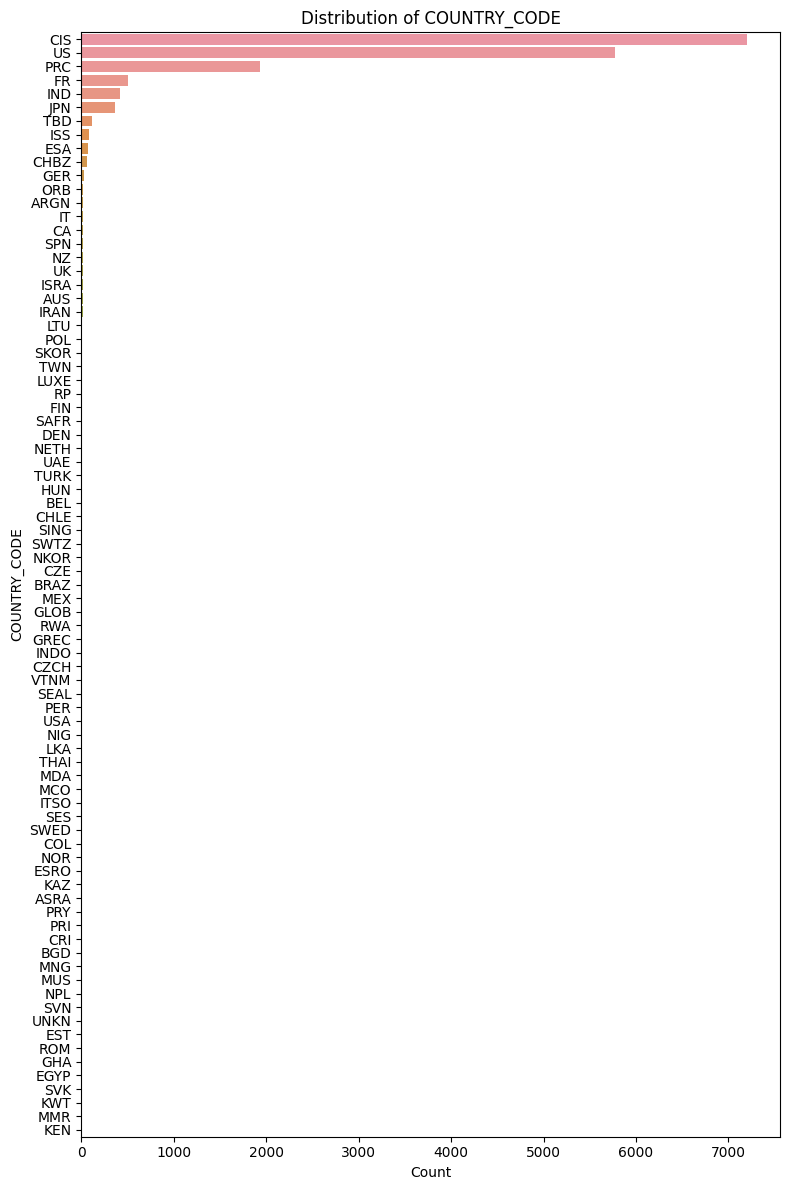

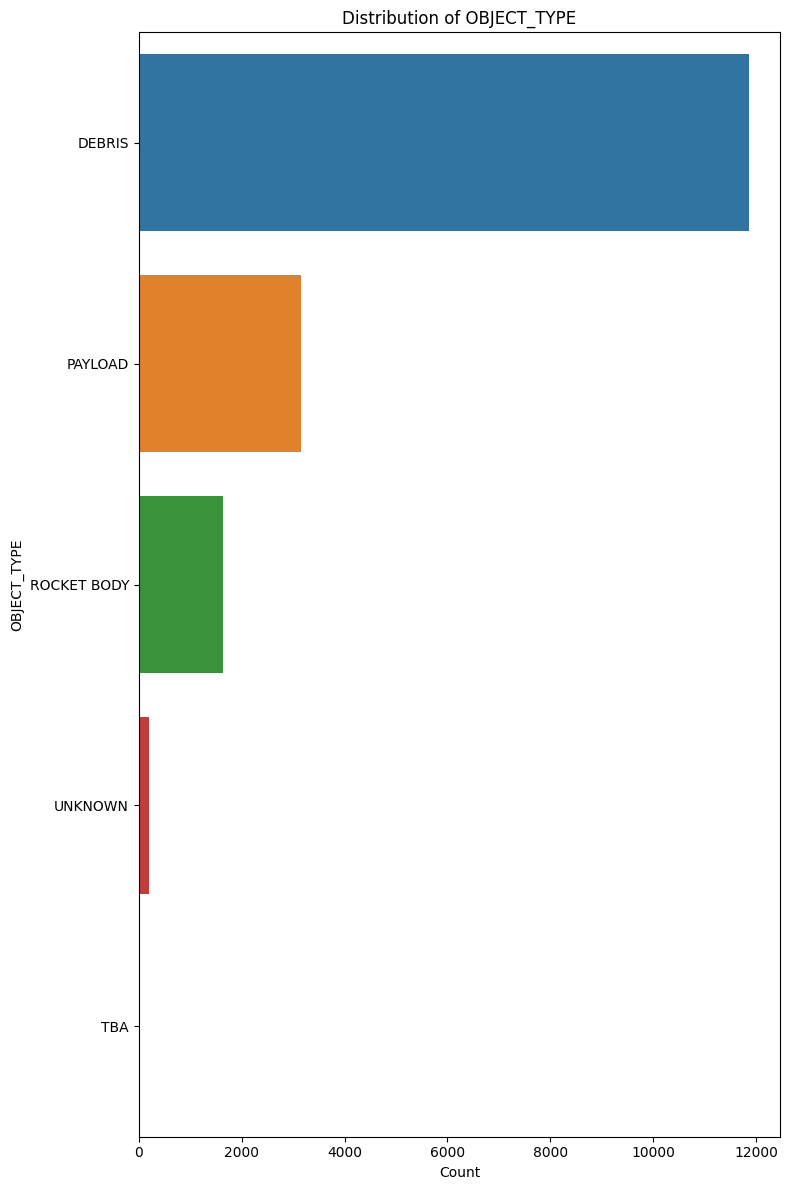

In [7]:
# List of categorical discriminative variables
categorical_discriminative_vars = ['COUNTRY_CODE', 'OBJECT_TYPE']

# Plot bar plots
plot_barplots(X_df, categorical_discriminative_vars)